Spin Piolarized and Time-Resolved EPR Spectroscopy in MarS.


This notebook demonstrates how to use the MarS library to compute spin polarized and time-resolved EPR spectra

We'll explore:

1) Context logic for describing spin relaxation mechanisms
2) Population-based relaxation dynamics
3) Rotating Wave Approximation and Lindblad formalism
4) Full propagator computation beyond approximations


\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru\
\
\
The last notebook update: 2026.01.27
\
\
Please, if you want to download this notebook to your computer visit https://github.com/ArkadySamsonenkoWork/MarS/tree/main/examples

In [1]:
# Import necessary libraries
import sys
import os
import math

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import Mars library components
import mars
from mars import spin_model, spectra_manager, mesher, constants
from mars import utils
from mars import population

# # Let's import some useful functions for plotting simulation results over time.
from mars import visualization

In [2]:
dtype = torch.float64
device = torch.device("cpu")

# 1. Context Logic and Spin-Polarized Systems

In time-resolved EPR, we need to model how spin systems evolve after initial excitation. The Context class in MarS provides a comprehensive framework for defining these relaxation mechanisms.


A Context encapsulates the physical model of relaxation and initial state in time-resolved EPR. It specifies:

1) The basis where relaxation parameters and initial populations are defined
2) Initial populations or density matrix
3) Probabilities of transitions and superoperators

### 1.1. Context Definition and Time Resolved Spectra

Here we introduce new object in MarS library - context. Context allows to describe relaxation mechanisms and initial populations

In [3]:
# Let's start from the sample creation

g_tensor = spin_model.Interaction(2.002, dtype=dtype, device=device)
zfs_interaction = spin_model.DEInteraction([500e6, 100e6], dtype=dtype, device=device)  # 500 and 100 MHz

base_spin_system = spin_model.SpinSystem(
    electrons=[1.0],  # S=1 triplet
    g_tensors=[g_tensor],
    electron_electron=[(0, 0, zfs_interaction)]
)

triplet = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system,
    ham_strain=3e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

Let's create Context object. It takes:

1) Initial populations if the populations are not under temperature equilibrium

2) Basis where the parameters are defined.

**Available Basis Options:**

1. **"eigen"** (default): Hamiltonian eigenbasis at resonance field

2. **"zfs"**: Zero-field splitting eigenbasis

3. **"xyz"**: xyz basis for triplet molecules

4. **"multiplet"**: Total spin basis |S, M⟩

5. **"product"**: Individual spin projections |ms₁, ms₂, ...⟩

5. **"zeeman"**: Bisis in infinite magnetic field.

5. **Custom tensor**: Explicit transformation matrix with shape [...R, 1 ,N, N], where N is spin dimension, R is numer of orientations

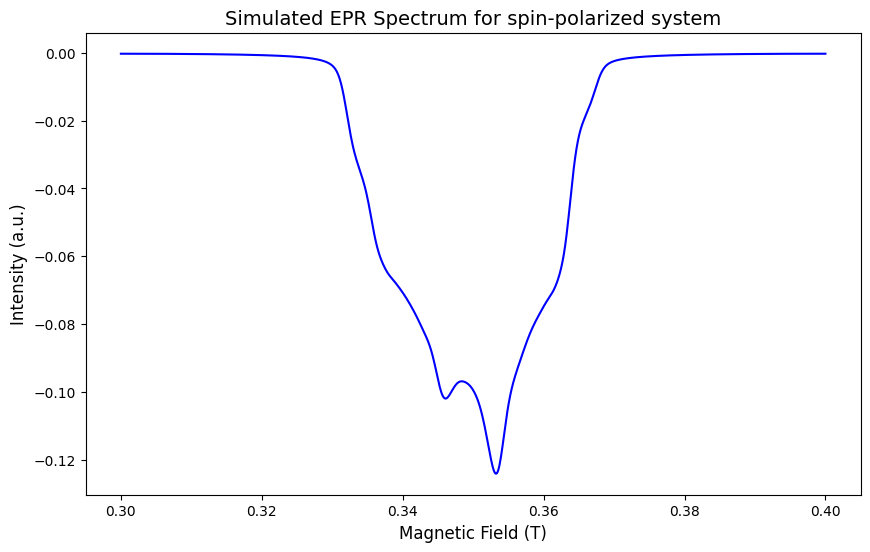

In [4]:
# Let's create some spectra with polarization
init_populations = [0.2, 0.3, 0.5] 

context = population.Context(sample=triplet, basis=None, init_populations=init_populations, device=device, dtype=dtype) 
# Here we define Context with populations given in the Hamiltonian eigen basis in magnetic field

# In most cases, the context requests a sample to obtain the basis vectors.
# This is only true if you don't specify a basis in a magnetic field (eigen or None).
# You can also set different samples for specifying the basis and for specifying the sample whose spectra you want to obtain.
# It can be useful for the creation spectra of some radical - triplet combinations. 


# StationarySpectra can take context to compute spin-polarized spectra
spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=triplet,
    harmonic=0, # absorbtion
    context=context,
    device=device,
    dtype=dtype
)

# Define magnetic field range for simulation
fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla

# Calculate spectrum
spectrum = spectra_creator(triplet, fields)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(fields.numpy(), spectrum.numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum for spin-polarized system', fontsize=14)
plt.show()

As a result we observe spin-polarized system.

### 1.2. Plot spin-polarized spectra for all possible predifined basis

Now, Let's plot spectra with populations given at all possible predefined basis

In [5]:
# Create function that makes it
def get_spectrum_with_context(context):
    spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=triplet,
    harmonic=0, # absorbtion
    context=context, 
    temperature=300.0,
    device=device,
    dtype=dtype
)

    # Define magnetic field range for simulation
    fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla
    # Calculate spectrum
    spectrum = spectra_creator(triplet, fields)
    
    return fields.cpu().numpy(), spectrum.cpu().numpy() / max(abs(spectrum.cpu().numpy()))

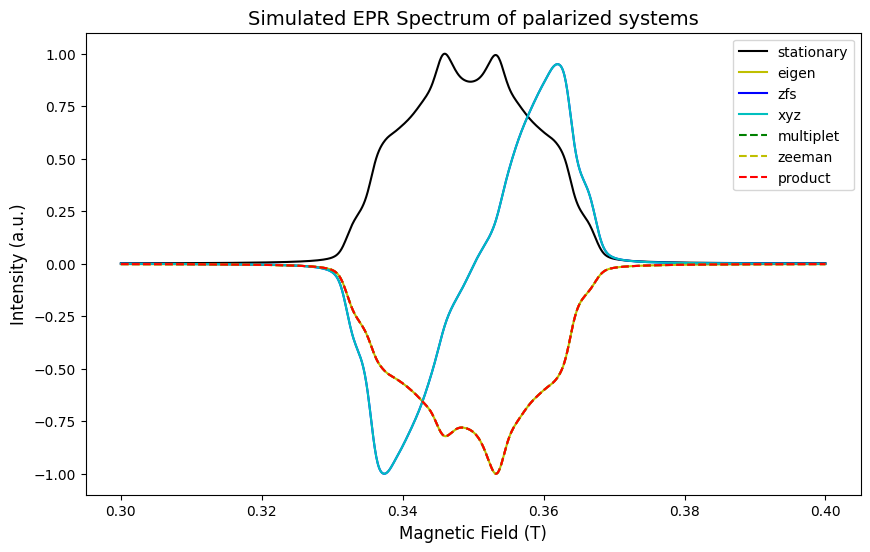

In [6]:
fields, spectrum_stationary = get_spectrum_with_context(None)  # stationary spectra

init_populations = [0.2, 0.3, 0.5] 
context = population.Context(sample=triplet, basis="zfs", init_populations=init_populations, device=device, dtype=dtype) 
fields, spectrum_zfs = get_spectrum_with_context(context)  # zfs spectra z, x, y

init_populations_xyz = [0.3, 0.5, 0.2] # To compare with zero-field spitting basis. It should be the same in this order as zero-field splitting
context = population.Context(sample=triplet, basis="xyz", init_populations=init_populations_xyz, device=device, dtype=dtype) 
fields, spectrum_xyz = get_spectrum_with_context(context)  # xyz spectra

context = population.Context(sample=triplet, basis="eigen", init_populations=init_populations, device=device, dtype=dtype) 
fields, spectrum_eigen = get_spectrum_with_context(context)  # eigen basis spectra

context = population.Context(sample=triplet, basis="multiplet", init_populations=init_populations, device=device, dtype=dtype) 
fields, spectrum_mul = get_spectrum_with_context(context)  # multiplet spectra

context = population.Context(sample=triplet, basis="zeeman", init_populations=init_populations, device=device, dtype=dtype) 
fields, spectrum_zeeman = get_spectrum_with_context(context)  # multiplet spectra


init_populations_product = [0.5, 0.3, 0.2]  # For the product basis we inverted the populations because product basis defined from the higher spin projection
context = population.Context(sample=triplet, basis="product", init_populations=init_populations_product, device=device, dtype=dtype) 
fields, spectrum_product = get_spectrum_with_context(context)  # product spectra



plt.figure(figsize=(10, 6))
plt.plot(fields, spectrum_stationary, 'black', label="stationary")
plt.plot(fields, spectrum_eigen, 'y-', label="eigen")
plt.plot(fields, spectrum_zfs, 'b-', label="zfs")
plt.plot(fields, spectrum_xyz, 'c', label="xyz")
plt.plot(fields, spectrum_mul, 'g--', label="multiplet")
plt.plot(fields, spectrum_mul, 'y--', label="zeeman")
plt.plot(fields, spectrum_product, 'r--', label="product")

plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of palarized systems', fontsize=14)
plt.legend()
plt.show()

We get expected result: \
In a magnetic field, the eigenbasis is practically equal to the multiplet basis, which is equal to the product basis and Zeeman Basis \
XYZ basis is the same as ZFS basis but in another order

# 2. Introduction to Time-Resolved Spectroscopy

In MarS, time-resolved EPR spectra are computed using three distinct methods, each with specific capabilities and limitations.

1) **Population (kinetic) dynamics**  
   This method solves a kinetic rate equation for the populations of spin energy levels:  

   $$
   \frac{d\mathbf{n}}{dt} = K \cdot \mathbf{n}(t),
   $$  

   where $\mathbf{n}$ is the vector of level populations and $K$ is the kinetic matrix.  
   It supports arbitrary spin Hamiltonians but cannot describe quantum coherences, coherent polarization transfer, or any effect that depends on off-diagonal elements of the density matrix.

2) **Density-based dynamics via rotating-wave approximation**  
   MarS provides two approaches to solve the full density matrix relaxation. Both solve the Liouville–von Neumann equation in Liouville space:  

   $$
   \frac{d\rho}{dt} = -i[H, \rho] + \mathcal{R}[\rho],
   $$  

   where $H$ is the Hamiltonian and $\mathcal{R}$ is the relaxation superoperator.  
   The first approach uses the rotating-wave approximation (RWA), which transforms the problem into a rotating frame. While computationally efficient, it imposes several key restrictions:
   - The g-tensor must be isotropic, so the Zeeman term takes the form  
     $G_x = g \mu_B S_x$, $G_y = g \mu_B S_y$, $G_z = g \mu_B S_z$., where Gx,  Gy, Gz are Zeeman Operators, $\mu_B$ is Bohr  Magneton
   - The static part of the Hamiltonian (denoted $F$) must commute with $G_z$: $[F, G_z] = 0$.
   - The relaxation superoperator $\mathcal{R}_{ijkl}$ (coupling matrix elements $\rho_{ij}$ and $\rho_{kl}$) is only non-zero when $i - j = k - l$.  
     This includes:
     - Population transfer between levels ($i = j$, $k = l$), including pure decay ($i = j = k = l$),
     - Pure dephasing of coherences ($i = k$, $j = l$).

3) **Propagator-based dynamics via explicit propagator computation**  
   This method computes the time-resolved EPR signal by explicitly evaluating the full time-evolution propagator $U(t, 0)$. The propagator is calculated over one period of the microwave field and then extended to arbitrary detection times using Floquet theory.  
   For disordered (powder) samples, the signal is averaged over the Euler angle $\gamma$ by evaluating responses to two orthogonal microwave polarizations.
   For this method any kind of Hamiltonian can be used

# 3. Population Dynamics

In MarS, relaxation within the population (kinetic) paradigm is defined by three distinct types of transition probabilities:

1. **Out probabilities (`out_probs`)** – probabilities at which population is irreversibly lost from each energy level (e.g., due to phosphorescence or chemical decay). These are diagonal loss terms.
2. **Free probabilities (`free_probs`)** – probabilities of *spontaneous* transitions between levels. After transformation into the eigenbasis of the full Hamiltonian, these are automatically adjusted to satisfy the principle of detailed balance at the specified temperature.
3. **Driven probabilities (`driven_probs`)** – probabilities of *stimulated* (e.g., microwave-induced) transitions. These are not modified to enforce detailed balance and remain as user-specified.

All probabilities are expressed in **s⁻¹** (inverse seconds).

In [7]:
init_populations = [0.5015, 0.5, 0.5015] # Let's make them almoust equel
init_populations  = [pop / sum(init_populations) for pop in init_populations]

out_probs = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype) * 100 # 10 ms is some depopulation time

# Level 0 ↔ Level 1 and Level 1 ↔ Level 2 at 1000 s⁻¹ (~1 ms equilibration).
# Note that you do not need to specify the diagonal elements manually, they are set automatically during calculations.
free_probs = torch.tensor([[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]], device=device, dtype=dtype) * 1000 # 1 ms is time of equilibration for triplet relaxation.

# No driven transitions in this example
driven_probs = None # Do not consider it here.

context = population.Context(sample=triplet, basis="eigen", init_populations=init_populations, out_probs=out_probs, free_probs=free_probs, device=device, dtype=dtype) 

In [8]:
# Let"s get statinary spectrum to compare with time-resolved results
_, stationary_spectrum = get_spectrum_with_context(None)

# We intoduce new spectra creator: CoupledTimeSpectra
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(  # The most parameters are the same
    freq=9.8e9,    # Frequency in Hz 
    sample=triplet,
    harmonic=0, # absorbtion
    context=context,
    temperature=300.0,
    device=device,
    dtype=dtype
)

# Define magnetic field range for simulation
fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla

# Time axes in long and short time scale
tot_points = 800
time_long = torch.linspace(0.0, 2e-2, tot_points, dtype=dtype, device=device)  # time in seconds, long time scale, up to 20ms
time_short = torch.linspace(0.0, 3e-4, tot_points, dtype=dtype, device=device)  # time in seconds, short time scale, up to 300µs

# Compute 2D spectra
spectrum_pop_long  = tr_spectra_creator(triplet, fields, time_long)
spectrum_pop_short = tr_spectra_creator(triplet, fields, time_short)

# Let"s plot normilized plots
normalization = np.max(np.abs(spectrum_pop_long.cpu().numpy()))
spectrum_pop_long_np = spectrum_pop_long.cpu().numpy() / normalization
spectrum_pop_short_np = spectrum_pop_short.cpu().numpy() / normalization

# Create time points to plot them
point_quart = tot_points // 4
point_end = tot_points - 1
long_scale_points = [point_quart, point_end]
short_scale_points = [point_quart, point_end]


# Let"s normalize stationary_spectrum on spectrum_pop_long_np[point_quart] for convinience to compare:
stationary_spectrum = stationary_spectrum * max(abs(spectrum_pop_long_np[point_quart]))

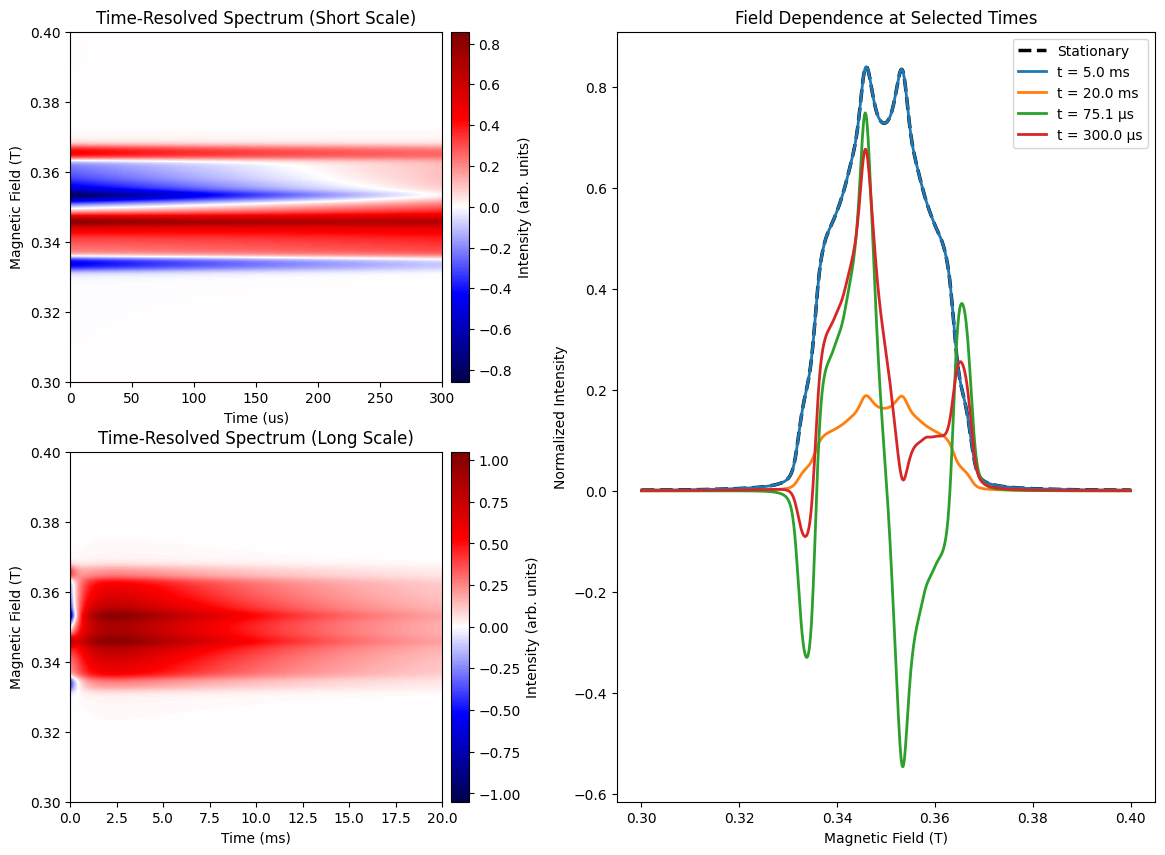

In [9]:
# Create figure with mosaic layout
fig, axes = plt.subplot_mosaic([["short", "slices"], ["long", "slices"]], figsize=(14, 10), 
                                gridspec_kw={"width_ratios": [1, 1.2]})

# Short timescale heatmap
plt.sca(axes["short"])
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_pop_short_np,
    time_unit="us",
)
plt.title("Time-Resolved Spectrum (Short Scale)")

# Long timescale heatmap
plt.sca(axes["long"])
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_pop_long_np,
    time_unit="ms",
)
plt.title("Time-Resolved Spectrum (Long Scale)")

# Field slices at specific times
plt.sca(axes["slices"])
plt.plot(fields.cpu().numpy(), stationary_spectrum, "--k", lw=2.5, label="Stationary")

# Long timescale slices
for idx in long_scale_points:
    t_val = time_long[idx].item()
    visualization.plot_field_dependence(
        t_val, fields, time_long, spectrum_pop_long_np,
        label=f"t = {t_val*1000:.1f} ms",
        lw=2
    )

# Short timescale slices
for idx in short_scale_points:
    t_val = time_short[idx].item()
    visualization.plot_field_dependence(
        t_val, fields, time_short, spectrum_pop_short_np,
        label=f"t = {t_val*1e6:.1f} μs",
        lw=2
    )

plt.xlabel("Magnetic Field (T)")
plt.ylabel("Normalized Intensity")
plt.title("Field Dependence at Selected Times")
plt.legend(loc="best")

plt.show()

Here we observe two effects:

1) Rapid relaxation to stationary spectra with 1 / free_probs time

2) Long-term decay of the triplet state

# 4. Density-Based Dynamics

MarS implements full density-matrix relaxation using the Liouville-von Neumann equation with relaxation superoperator:

$$
\frac{d\rho}{dt} = -i[H, \rho] + \mathcal{R}[\rho],
$$

where $\rho$ is the density matrix, $H$ is the spin Hamiltonian, and $\mathcal{R}$ is the relaxation superoperator.

To connect level-base approach and density - computation approach MarS uses the Lindblad formalism to write free probabilities, out probabilities, driven probabilitie and dephasing, which guarantees physical validity (positivity and trace preservation) of the evolving quantum state.

In this case relaxation superoperator $\mathcal{R}$ can be expressed as a sum over Lindblad ("jump") operators $L_k$:

$$
\mathcal{R}[\rho] = \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \{ L_k^\dagger L_k, \rho \} \right).
$$

MarS maps user-defined relaxation parameters directly onto specific jump operators:

---

### 1. **Out probabilities (`out_probs`)**  
To model irreversible loss.
- The next jump operator is used: $L_i = \sqrt{o_i}\, |i\rangle\langle i|$, where $\sqrt{o_i}$ is probability of loss from the level

---

### 2. **Free probabilities (`free_probs`)**  
Describe *spontaneous* transitions $|j\rangle \to |i\rangle$ that obey detailed balance at temperature $T$:  
- The next jump operator is used: $L_{ij} = \sqrt{w_{ij}}\, |i\rangle\langle j|$, where $\sqrt{w_{ij}}$ is probability of the transitions between levels

---

### 3. **Driven probabilities (`driven_probs`)**  
Represent *stimulated* transitions (e.g., microwave-induced flips).  
- The next jump operator is used: $L_{ij} = \sqrt{d_{ij}}\, |i\rangle\langle j|$ , where $\sqrt{d_{ij}}$  is probability of the transitions between levels

---

### 4. **Dephasing (`dephasing`)**  
Pure dephasing between levels $|i\rangle$ and $|j\rangle$ ($i \neq j$):  
- The next jump operator is used: $L_i = \sqrt{\gamma_i}\, |i\rangle\langle i|$, where $\gamma_i$ is probability of dephasing

---

### 5. **User-Defined superoperators (`relaxation_superop`)**  
Also it is possible to set the user-defined superoperator at the given basis




All jump operators are first defined in the user-specified basis (e.g., `"zfs"`), then transformed into the eigenbasis of the full Hamiltonian before assembly into $\mathcal{R}$.
Internally, MarS separates the total relaxation superoperator into two parts:

- $\hat{\mathcal{R}}_{\text{free}}$: includes `out_probs`, `free_probs`, and `dephasing`. This part enforces detailed balance.
- $\hat{\mathcal{R}}_{\text{driv}}$: contains only `driven_probs`. This part remained unmodified



In any case MarS solve equation:

$$
\frac{d\rho}{dt} = -i[H, \rho] + \mathcal{R}[\rho],
$$

transforming it to Liouvillian space where Hamiltonian and relaxation superoperators have dimension $N^2$ x $N^2$ and density matrix has dimension $N^2$. In this case MarS propose two methods how to solve this equation

### 4.1 Rotating Wave Approximation (RWA)

One of the way to solve the Rotating Wave Approximation. In the Rotating Wave Approximation (RWA), the time-dependent Hamiltonian is transformed into a time-independent effective Hamiltonian by moving to a frame rotating at the driving frequency $\omega$. Under the following assumptions:

1. The transverse magnetic field is circularly polarized,
2. The $g$-tensor is isotropic, so that $\hat{G}_\alpha = g \mu_\mathrm{B} \hat{S}_\alpha$ ($\alpha = x, y, z$),
3. The static part $\hat{F}$ of the Hamiltonian commutes with $\hat{S}_z$: $[\hat{F}, \hat{S}_z] = 0$,

the total Hamiltonian in the rotating frame becomes:

$$
\hat{H}_\mathrm{eff} = \hat{F} + g \mu_\mathrm{B} B_z \hat{S}_z - \omega \hat{S}_z + g \mu_\mathrm{B} B_1 \hat{S}_x,
$$

or, more compactly,

$$
\hat{H}_\mathrm{eff} = \hat{H}_0 - \omega \hat{S}_z + g \mu_\mathrm{B} B_1 \hat{S}_x,
$$

where $\hat{H}_0 = \hat{F} + g \mu_\mathrm{B} B_z \hat{S}_z$ is the static Zeeman-plus-rest Hamiltonian, $B_1$ is the amplitude of the circularly polarized transverse field, and $\omega$ is the angular frequency of the driving field.

The Liouville–von Neumann equation for the density matrix $\hat{\rho}$ in this frame reads:

$$
\frac{d\hat{\tilde{\rho}}}{dt} = -i [\hat{H}_\mathrm{eff}, \hat{\rho}] + \mathcal{R}[\hat{\rho}],
$$

\
\
It is quite simple but it has some limitations:
1. The oscillating magnetic field (e.g., microwave or RF) is assumed to be circularly polarized.

2. The $g$-tensor must be isotropic or close to isotropic, so that the Zeeman operators are proportional to the spin operators:  
   $\hat{G}_x = g_x \mu_\mathrm{B} \hat{S}_x$,  
   $\hat{G}_y = g_y \mu_\mathrm{B} \hat{S}_y$,  
   $\hat{G}_z = g_z \mu_\mathrm{B} \hat{S}_z$.
   
In general, in MarS under RWA, we modify Gx, Gy, and Gz by default to make them approximately commute with the corresponding total spin projection operators Gx, Gy, and Gz.

3. The static part of the Hamiltonian (denoted $\hat{F}$) must commute with $\hat{S}_z$:  
   $[\hat{F}, \hat{S}_z] = 0$.

4. The relaxation superoperator $\mathcal{R}_{ijkl}$—which couples density matrix elements $\rho_{ij}$ and $\rho_{kl}$ - is non-zero only when  
   $i - j = k - l$.  
   This condition includes two physical processes:
   - Population transfer between energy levels ($i = j$, $k = l$), including pure decay ($i = j = k = l$).
   - Dephasing of coherences ($i = k$, $j = l$).

When the dipolar interaction is small and the sample is organic it works good and it is default method in MarS for density-based time-resolved computations. 
Let's consider it and define context

In [10]:
# For any density computations it is better to use some dephasing to preserve spectra saturation by magnetic field
dephasing = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype) * 1e4 # 100 µs is ann additioanl time to T2 relaxation.


# Other parameters are from the previous task
context = population.Context(
    sample=triplet, basis="eigen",
    init_populations=init_populations, dephasing=dephasing,
    out_probs=out_probs, free_probs=free_probs,
    device=device, dtype=dtype) 

Here we implement DensityTimeSpectra class for computations of ttimeime-resolved spectroscopy in density-based approach. By default it uses RWA and secular approximation to force [F, Sz] = 0 

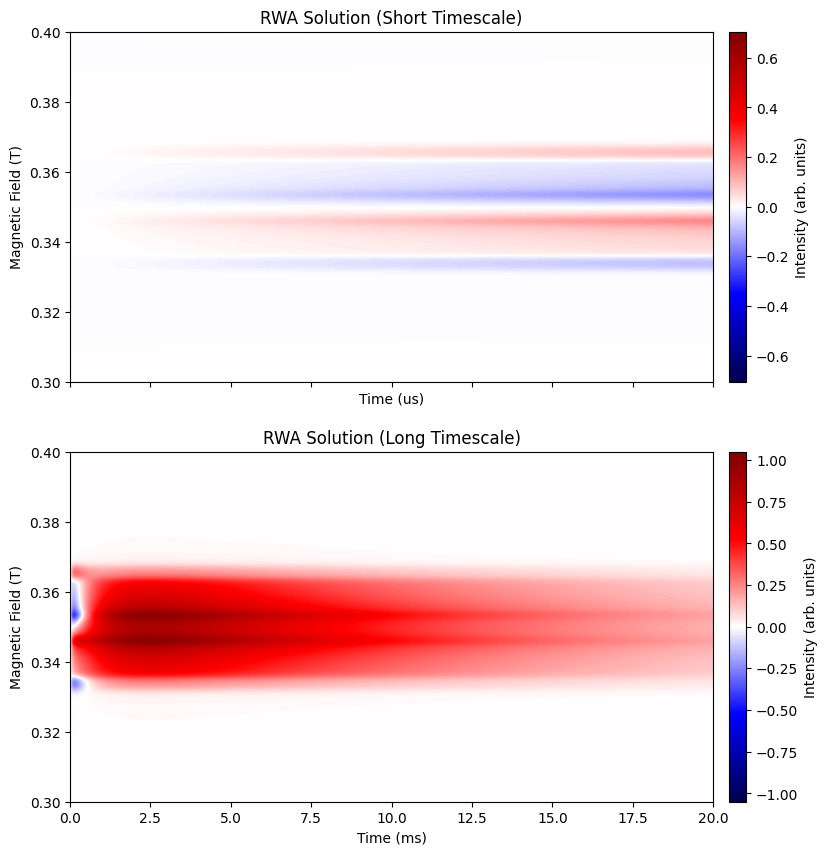

In [11]:
# Compute spectra
tr_spectra_creator_rwa = spectra_manager.DensityTimeSpectra(
    freq=9.8e9,    # Frequency in Hz 
    sample=triplet,
    harmonic=0, # absorbtion
    context=context,
    temperature=300.0,
    device=device,
    dtype=dtype
)

spectrum_rwa_short = tr_spectra_creator_rwa(triplet, fields, time_short)
spectrum_rwa_long = tr_spectra_creator_rwa(triplet, fields, time_long)

# Normalize using long-time scale max
normalization_rwa = np.max(np.abs(spectrum_rwa_long.cpu().numpy()))
spectrum_rwa_long_np = spectrum_rwa_long.cpu().numpy() / normalization_rwa
spectrum_rwa_short_np = spectrum_rwa_short.cpu().numpy() / normalization_rwa

# Plotting
fig, (ax_short, ax_long) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Short timescale
plt.sca(ax_short)
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_rwa_short_np,
    time_unit="us",
)
plt.title("RWA Solution (Short Timescale)")

# Long timescale
plt.sca(ax_long)
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_rwa_long_np,
    time_unit="ms",
)
plt.title("RWA Solution (Long Timescale)")
plt.show()

Yes, it seems pretty close. The main difference is in the behavior at the beginning, when there is no transverse magnetization and the spectrum is zero. Let's compare with population-based spectra

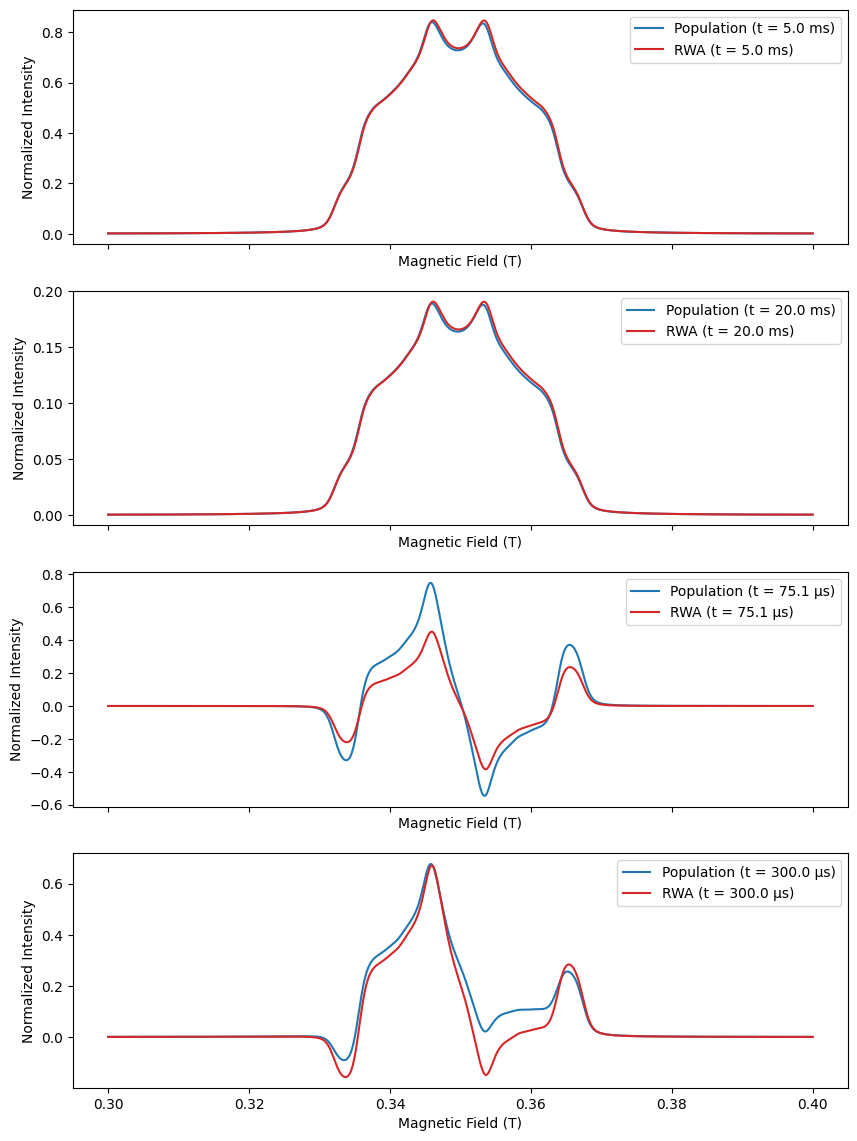

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(10, 14), sharex=True)

# Define actual time values (in seconds) for slicing
time_points_long = [time_long[i].item() for i in long_scale_points]      # e.g., [0.005, 0.02]
time_points_short = [time_short[i].item() for i in short_scale_points]   # e.g., [7.5e-5, 3e-4]

# --- Long timescale comparisons ---
for i, t_val in enumerate(time_points_long):
    plt.sca(axes[i])
    
    # Population solution
    visualization.plot_field_dependence(
        t_val, fields, time_long, spectrum_pop_long_np,
        label=f"Population (t = {t_val * 1e3:.1f} ms)",
        color="tab:blue",
        lw=1.5
    )
    
    # RWA solution
    visualization.plot_field_dependence(
        t_val, fields, time_long, spectrum_rwa_long_np,
        label=f"RWA (t = {t_val * 1e3:.1f} ms)",
        color="tab:red",
        lw=1.5,
    )
    
    plt.ylabel("Normalized Intensity")
    plt.legend(loc="best")

# --- Short timescale comparisons ---
for i, t_val in enumerate(time_points_short, start=2):
    plt.sca(axes[i])
    
    # Population solution
    visualization.plot_field_dependence(
        t_val, fields, time_short, spectrum_pop_short_np,
        label=f"Population (t = {t_val * 1e6:.1f} µs)",
        color="tab:blue",
        lw=1.5
    )
    
    # RWA solution
    visualization.plot_field_dependence(
        t_val, fields, time_short, spectrum_rwa_short_np,
        label=f"RWA (t = {t_val * 1e6:.1f} µs)",
        color="tab:red",
        lw=1.5,
    )
    
    plt.ylabel("Normalized Intensity")
    plt.legend(loc="best")

plt.xlabel("Magnetic Field (T)")
plt.show()

The spectra appear identical on long time scales. Minor differences arise from the use of the secular approximation in RWA calculations. The initial spectra differ due to the inclusion of the relaxation time of the transverse magnetization.

### 4.2 Solution with Propagator computations

Another method for calculating time-resolved spectra based on density matrix relaxation is to use a propagator calculation based on Floquet theory. This approach does not have the same limitations, but it is more time-consuming.

In this method, the Hamiltonian remains explicitly time-dependent due to the oscillating microwave field, and the evolution of the density matrix $\hat{\rho}(t)$ is governed by:

$$
\frac{d\hat{\rho}}{dt} = -i [\hat{H}(t), \hat{\rho}(t)] + \mathcal{R}[\hat{\rho}(t)],
$$

where $\hat{H}(t) = \hat{H}_0 + \hat{H}_1 \cos(\omega t)$ includes the static part $\hat{H}_0$ and the transverse oscillating field $\hat{H}_1$, and $\mathcal{R}$ is the relaxation superoperator.

The *propagator** $\mathcal{G}(t, t_0)$ is the linear superoperator that evolves the density matrix from time $t_0$ to $t$, defined by $\hat{\rho}(t) = \mathcal{G}(t, t_0)\,\hat{\rho}(t_0)$. It satisfies the Liouville–von Neumann equation in superoperator form:

$$
\frac{d}{dt}\mathcal{G}(t, 0) = \big( -i\hat{\hat{H}}(t) + \mathcal{R} \big)\, \mathcal{G}(t, 0),
$$

where $\hat{\hat{H}}(t) = [\hat{H}(t), \cdot]$ is the hamiltonian in Liouvillian space.

Because the oscillating field is periodic with period $T = 2\pi/\omega$, the evolution operator (propagator) over one period, $\mathcal{G}(T, 0)$, can be computed efficiently using Floquet theory. The full propagator at time $t = kT + \tau$ (with integer $k$ and $0 \leq \tau < T$) can be expressed as:

$$
\mathcal{G}(t, 0) = \mathcal{G}(\tau, 0) \cdot \big[\mathcal{G}(T, 0)\big]^k.
$$

In practice, MarS computes two key quantities over a single microwave period:
- The *period propagator* $\mathcal{G}(T, 0)$,
- The *mean propagator over period* $\displaystyle \int_0^T \mathcal{G}(t, 0) \sin(\omega t)\, dt$,

This approach supports arbitrary $g$-tensor anisotropy, general zero-field splitting tensors, and unrestricted relaxation superoperators-unlike the Rotating Wave Approximation.

Let's write the relaxation via the propagator computations:

1) We need to set it in DensityTimeSpectra initialization

2) Or if we want to perform more difficult computations we should define populator

3) Also it is better to switch from secular to res-field compuations of resonance lines. 'hamiltonian_mode' is used to set appropriate computation method

In [13]:
# Compute spectra
tr_spectra_creator_prop = spectra_manager.DensityTimeSpectra(
    freq=9.8e9,    # Frequency in Hz 
    sample=triplet,
    harmonic=0, # absorbtion
    context=context,
    temperature=300.0,
    populator = "propagator", # Define propagator approach to compute spectra
    hamiltonian_mode="direct",  # DensityTimeSpectra has default hamiltonian_mode equel to secular. Now we want to use direct computation of eigen vectors (via res-field)
    device=device,
    dtype=dtype
)

spectrum_prop_short = tr_spectra_creator_prop(triplet, fields, time_short)
spectrum_prop_long = tr_spectra_creator_prop(triplet, fields, time_long)

# normalize them
normalization = np.max(np.abs(spectrum_prop_long.cpu().numpy()))
spectrum_prop_long_np = spectrum_prop_long.cpu().numpy() / normalization
spectrum_prop_short_np = spectrum_prop_short.cpu().numpy() / normalization

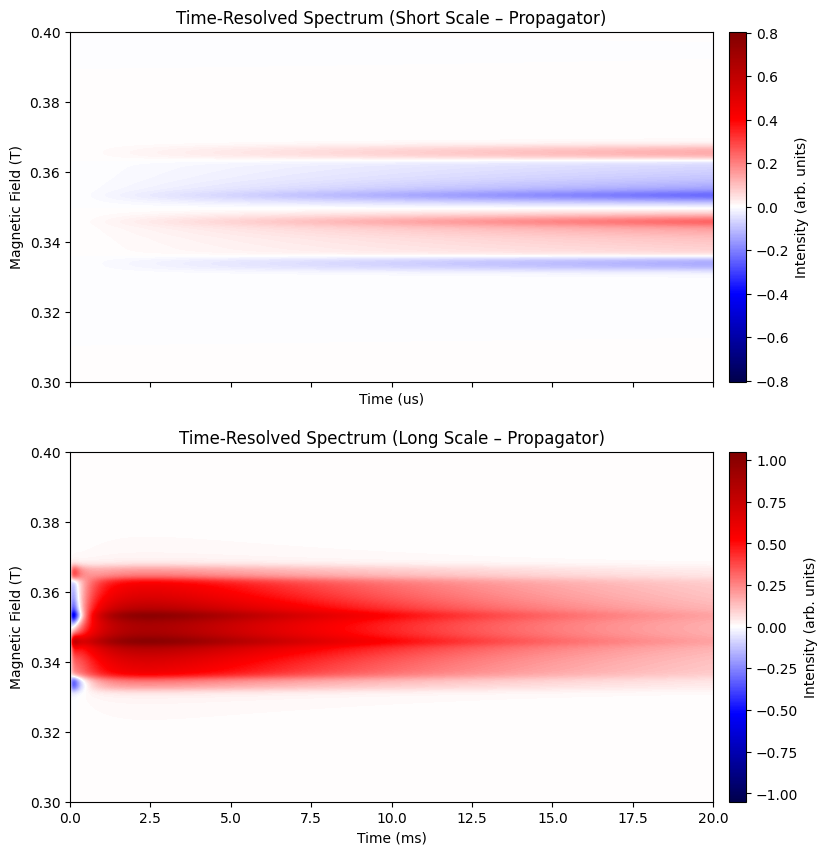

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

plt.sca(ax0)
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_prop_short_np,
    time_unit="us",
    cmap="seismic"
)
plt.title("Time-Resolved Spectrum (Short Scale – Propagator)")

plt.sca(ax1)
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_prop_long_np,
    time_unit="ms",
    cmap="seismic"
)

plt.title("Time-Resolved Spectrum (Long Scale – Propagator)")
plt.show()

### 4.3 Setting up a populator

For some advance case it can be convinient to set populator by your own.

In [15]:
populator_prop = population.PropagatorDensityPopulator(
    omega_intensity=100, # Default walue of oscillating field intensity in Hz / 2pi
    context=context,
    measurement_time=1e-6, # By default MarS measures intensity in one oscillating period. Let's set this time as 1 µs. 
    init_temperature=300.0,
    n_steps=120, # For some cases this value can be ctucial. It significanlty increase the computation time. However if it is low, then the results will be broken. Usually 100-200 is more then enough
)

In [16]:
# Compute spectra
tr_spectra_creator_prop = spectra_manager.DensityTimeSpectra(
    freq=9.8e9,
    sample=triplet,
    harmonic=0,
    context=context,
    temperature=300.0,
    populator=populator_prop, # Our predefined populator
    hamiltonian_mode="direct",
    device=device,
    dtype=dtype
)

spectrum_prop_short = tr_spectra_creator_prop(triplet, fields, time_short)
spectrum_prop_long = tr_spectra_creator_prop(triplet, fields, time_long)

# normalize them
normalization = np.max(np.abs(spectrum_prop_long.cpu().numpy()))
spectrum_prop_long_np = spectrum_prop_long.cpu().numpy() / normalization
spectrum_prop_short_np = spectrum_prop_short.cpu().numpy() / normalization

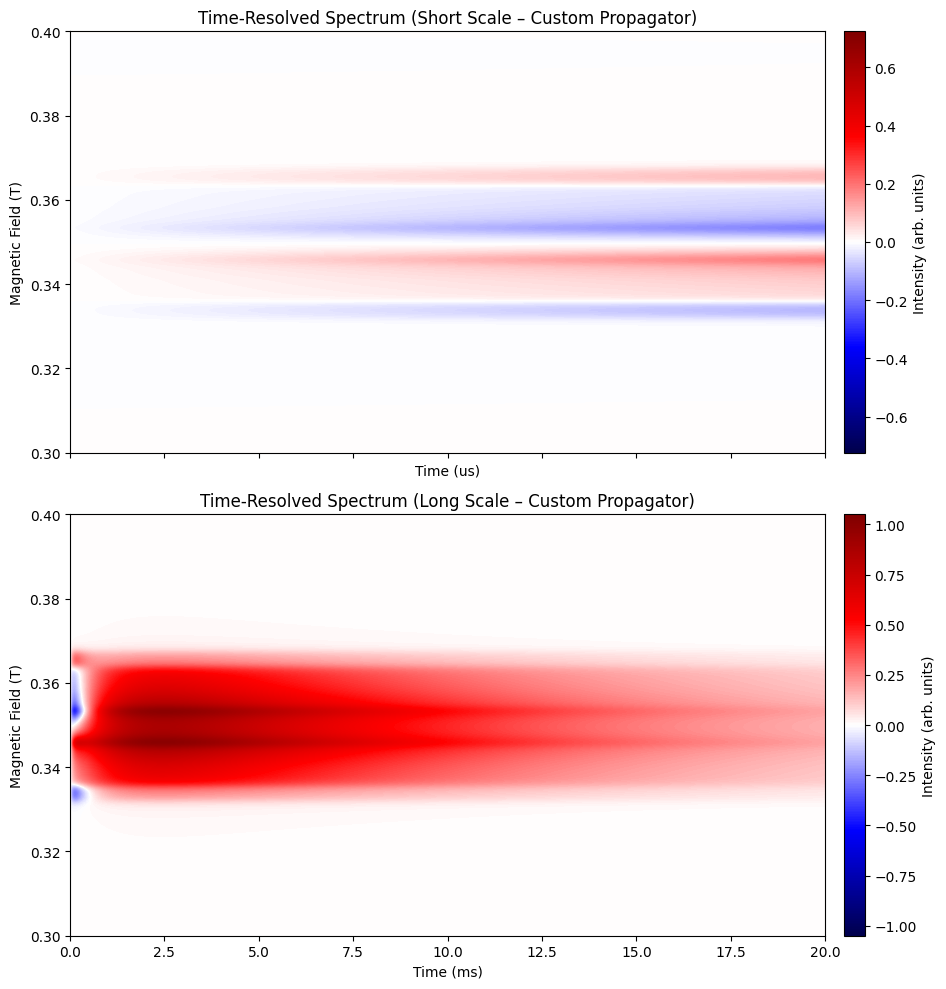

In [17]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

plt.sca(ax0)
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_prop_short_np,
    time_unit="us",
    cmap="seismic"
)
plt.title("Time-Resolved Spectrum (Short Scale – Custom Propagator)")

plt.sca(ax1)
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_prop_long_np,
    time_unit="ms",
    cmap="seismic"
)
plt.title("Time-Resolved Spectrum (Long Scale – Custom Propagator)")

plt.tight_layout()
plt.show()

# 5. Context Algebra

MarS allows the construction of complex `Context` objects to describe realistic relaxation scenarios by combining simpler mechanisms. Three fundamental algebraic operations are supported:

- **Addition** (`context_1 + context_2`): combines independent relaxation pathways acting on the *same* spin system.
- **Multiplication** (`context_1 @ context_2`): constructs a composite system from *independent particles*, each with its own relaxation.
- **Concatenation** (`mars.concat((context_1, context_2))`): constructs a composite system of energy levels from independent subsystems, each with its own relaxation.

All three operations automatically handle basis transformations, detailed balance enforcement, and composition of kinetic matrices or relaxation superoperators.

---

### 5.1. "Sum" of Relaxation Mechanisms

The addition of contexts corresponds to the physical situation where multiple relaxation processes (e.g., spin–lattice relaxation and phosphorescence) act simultaneously on the same set of states. In this case, the total relaxation operator is the sum of individual contributions after transformation into the common eigenbasis of the full Hamiltonian.


For population dynamics (kinetic approach), the final kinetic matrix is:
$$
K_{\text{total}} = K^{(1)} + K^{(2)} + \cdots
$$

For density-matrix dynamics, the total relaxation superoperator becomes:
$$
\hat{\mathcal{R}}_{\text{total}} = \hat{\mathcal{R}}^{(1)} + \hat{\mathcal{R}}^{(2)} + \cdots
$$

Let's return to the example of the triplet state. MarS context can be operates with several mechanisms at the same time

<img src="sum_context.png" alt="Drawing" style="width: 800px;"/>


In this system there are two relaxation mechanisms

1) Depopulation given in ZFS basis (or the same in the X,Y,Z) basis

2) Relaxation between levels given in eigen basis of spin hamiltonina

In [18]:
# This part is the same as in previous examples

init_populations = [0.5015, 0.5, 0.5015] # Let's make them almoust equel
init_populations  = [pop / sum(init_populations) for pop in init_populations]

out_probs = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype) * 100 # 10 ms is some depopulation time

# Level 0 ↔ Level 1 and Level 1 ↔ Level 2 at 1000 s⁻¹ (~1 ms equilibration).
# Note that you do not need to specify the diagonal elements manually, they are set automatically during calculations.
free_probs = torch.tensor([[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]], device=device, dtype=dtype) * 1000 # 1 ms is time of equilibration for triplet relaxation.

# No driven transitions in this example
driven_probs = None # Do not consider it here.

Here we set two contexts and sum up the.

In [19]:
# We set context with basis in zero field splitting and define populations and out relaxation in this basis
context_zfs = population.Context(sample=triplet, basis="zfs", init_populations=init_populations, out_probs=out_probs, device=device, dtype=dtype)

# We set context with basis in hamiltonian with magnetic field  and set triplet relaxation in this basis
context_eigen = population.Context(sample=triplet, basis="eigen", free_probs=free_probs, device=device, dtype=dtype)

# And create complex realaxation context
context_tot = context_zfs + context_eigen

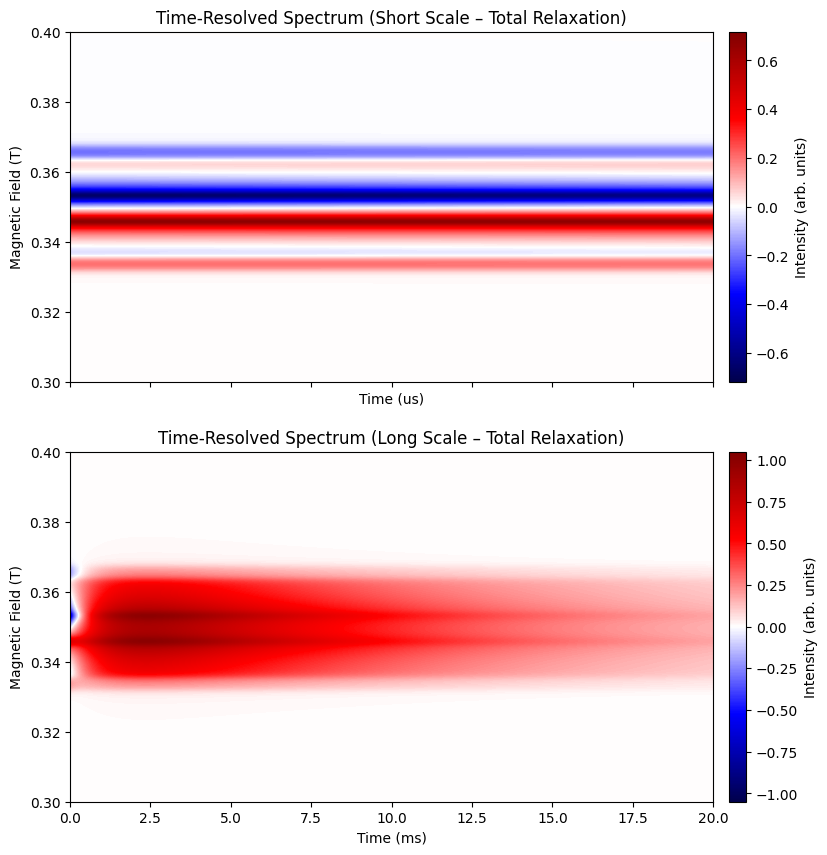

In [20]:
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(  # The most parameters are the same
    freq=9.8e9, 
    sample=triplet,
    harmonic=0,
    context=context_tot,  # Here we set total relaxation context
    temperature=300.0,
    device=device,
    dtype=dtype
)

fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla
tot_points = 800
time_long = torch.linspace(0.0, 2e-2, tot_points, dtype=dtype, device=device)  # time in seconds, long time scale, up to 20ms
time_short = torch.linspace(0.0, 3e-4, tot_points, dtype=dtype, device=device)  # time in seconds, short time scale, up to 300µs

spectrum_tot_long  = tr_spectra_creator(triplet, fields, time_long)
spectrum_tot_short = tr_spectra_creator(triplet, fields, time_short)

# Normalize
normalization = np.max(np.abs(spectrum_tot_long.cpu().numpy()))
spectrum_tot_long_np = spectrum_tot_long.cpu().numpy() / normalization
spectrum_tot_short_np = spectrum_tot_short.cpu().numpy() / normalization

# Plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

plt.sca(ax0)
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_tot_short_np,
    time_unit="us",
)
plt.title("Time-Resolved Spectrum (Short Scale – Total Relaxation)")

plt.sca(ax1)
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_tot_long_np,
    time_unit="ms",
)
plt.title("Time-Resolved Spectrum (Long Scale – Total Relaxation)")

plt.show()

### 5.2. "Multiplication" of Relaxation Mechanisms

The tensor product (`@`) of contexts describes a system consisting of two (or more) weakly coupled or independent spin-centers. The total Hilbert space is the tensor product of subsystem spaces, and initial states as well as relaxation operators combine accordingly.

For populations and kinetic matrises:
$$
\mathbf{n}_{\text{total}} = \mathbf{n}^{(1)} \otimes \mathbf{n}^{(2)}, \quad
K_{\text{total}} = K^{(1)} \otimes I^{(2)} + I^{(1)} \otimes K^{(2)}
$$

For density matrices and superoperators:
$$
\rho_{\text{total}} = \rho^{(1)} \otimes \rho^{(2)}, \quad
\hat{\mathcal{R}}_{\text{total}} = \hat{\mathcal{R}}^{(1)} \otimes \hat{I}^{(2)} + \hat{I}^{(1)} \otimes \hat{\mathcal{R}}^{(2)}
$$
where $\hat{I}^{(k)}$ denotes the identity superoperator acting on subsystem $k$.

Let's consider an example of two identical triplets connected by small dopolar-interaction.

In [21]:
# Let's define triplet sample and two triplets, conntected by dipolar interaction
# The triplet definition as in the beggining
g_tensor = spin_model.Interaction(2.002, dtype=dtype, device=device)
zfs_interaction = spin_model.DEInteraction([500e6, 100e6], dtype=dtype, device=device)  # 500 and 100 MHz

base_spin_system = spin_model.SpinSystem(
    electrons=[1.0],  # S=1 triplet
    g_tensors=[g_tensor],
    electron_electron=[(0, 0, zfs_interaction)]
)

triplet = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system,
    ham_strain=3e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

# The two-triplets definition as in the beggining
dipolar_interaction = spin_model.DEInteraction([100e6, 20e6], dtype=dtype, device=device)  # 100 and 20 MHz

base_spin_system_dipolar = spin_model.SpinSystem(
    electrons=[1.0, 1.0],  # S=1, 1 two triplets
    g_tensors=[g_tensor, g_tensor],
    electron_electron=[(0, 0, zfs_interaction), (1, 1, zfs_interaction), (0, 1, dipolar_interaction)]
)

dipol_triplets = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system_dipolar,
    ham_strain=3e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

Let's define the multiplication context

In [22]:
# We set context for the first triplet
context_zfs_1 = population.Context(sample=triplet, basis="zfs", init_populations=init_populations, out_probs=out_probs, device=device, dtype=dtype)

# We set context for the second triplet. Yes, they are the same
context_zfs_2 = population.Context(sample=triplet, basis="zfs", init_populations=init_populations, out_probs=out_probs, device=device, dtype=dtype)


# And create complex realaxation context
context_mul = context_zfs_1 @ context_zfs_2

# Also, one can add to this term another context with its eigen basis for relaxation between zeeman sublevels.

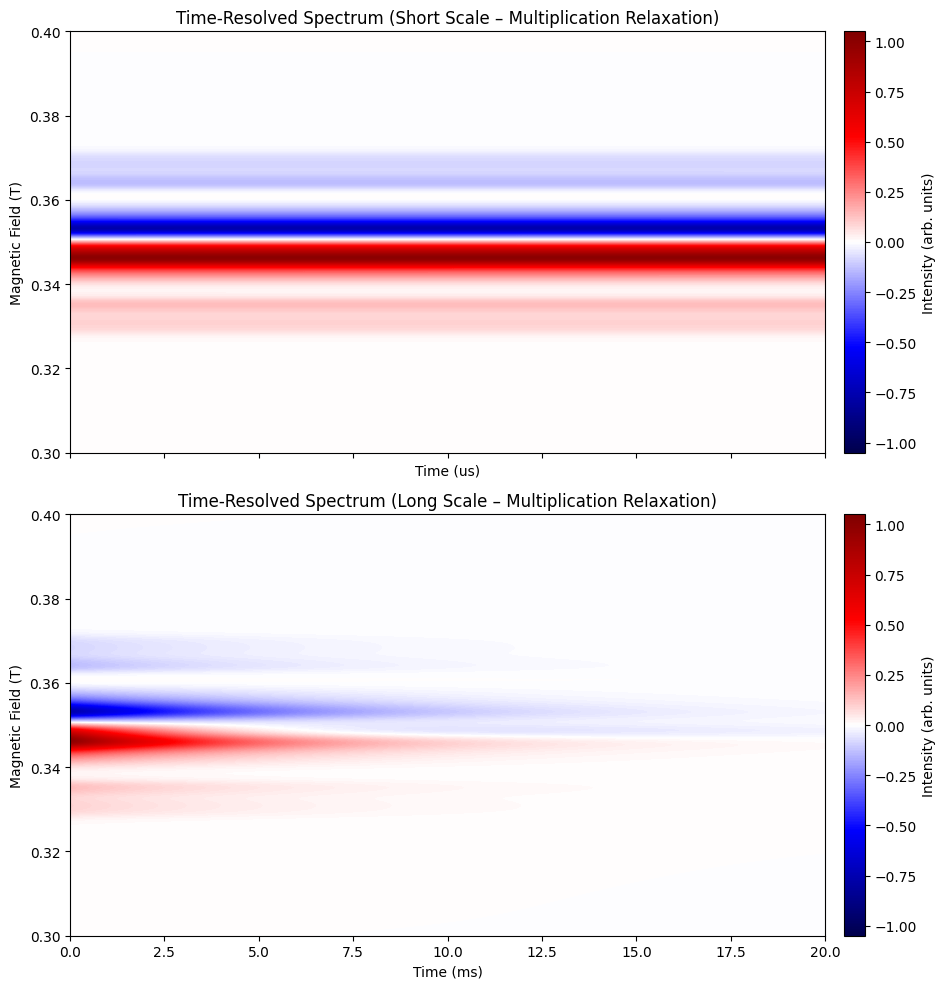

In [23]:
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(  # The most parameters are the same
    freq=9.8e9, 
    sample=dipol_triplets,   # Now we here another sample with 9 levels
    harmonic=0,
    context=context_mul,  # Here we set mutual relaxation context
    temperature=300.0,
    device=device,
    dtype=dtype
)

fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla
mul_points = 800
time_long = torch.linspace(0.0, 2e-2, mul_points, dtype=dtype, device=device)  # time in seconds, long time scale, up to 20ms
time_short = torch.linspace(0.0, 3e-4, mul_points, dtype=dtype, device=device)  # time in seconds, short time scale, up to 300µs

spectrum_mul_long  = tr_spectra_creator(dipol_triplets, fields, time_long)   # change the sample
spectrum_mul_short = tr_spectra_creator(dipol_triplets, fields, time_short)  # change the sample

# Normalize
normalization = np.max(np.abs(spectrum_mul_long.cpu().numpy()))
spectrum_mul_long_np = spectrum_mul_long.cpu().numpy() / normalization
spectrum_mul_short_np = spectrum_mul_short.cpu().numpy() / normalization

# Plotting
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Short timescale
plt.sca(ax0)
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_mul_short_np,
    time_unit="us",
)
plt.title("Time-Resolved Spectrum (Short Scale – Multiplication Relaxation)")

# Long timescale
plt.sca(ax1)
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_mul_long_np,
    time_unit="ms",
)
plt.title("Time-Resolved Spectrum (Long Scale – Multiplication Relaxation)")

plt.tight_layout()
plt.show()

Here we observe that the decay of two multiplied triplet states is faster than that of a single triplet state. However, in real physical systems, relaxation does not occur directly from the combined state $|T_1\rangle \otimes |T_2\rangle$ to the singlet state. Instead, it proceeds toward the individual $|T_1\rangle$ and $|T_2\rangle$ states which may also be experimentally observable.

### 5.3. "Concatination" of Relaxation Mechanisms

The concatination ('mars.concat') of contexts describes a system consisting of two (or more) independant subsistems of the one group of spin-centers. The total Hilbert space is the direct sum of subsystem spaces, and initial states as well as relaxation operators combine accordingly.

For populations (kinetic picture):
$$
\mathbf{n}_{\text{total}} = \mathbf{n}^{(1)} \oplus  \mathbf{n}^{(2)}, \quad
K_{\text{total}} = K^{(1)} \oplus K^{(2)}
$$

For density matrices and superoperators:
$$
\rho_{\text{total}} = \rho^{(1)} \oplus \rho^{(2)}, \quad
\hat{\mathcal{R}}_{\text{total}} = \hat{\mathcal{R}}^{(1)} \oplus \hat{\mathcal{R}}^{(2)}
$$

Let's consider the system of two triplet states with some energy gap with some additional transitions between them. 

**Here we should note**, this model applies strictly to the slow exchange regime where inter-subspace transition rates are negligible compared to intra-subspace relaxation rates. When the coupling strength is significant, the system enters the fast exchange regime, where the energy-isolated subspaces hybridize, and the dynamics must be described by a single unified density matrix evolving under a combined Hamiltonian and Lindblad superoperator - not by concatenation.

Let's define the sample

In [24]:
g_tensor = spin_model.Interaction(2.002, dtype=dtype, device=device)
zfs_interaction = spin_model.DEInteraction([500e6, 100e6], dtype=dtype, device=device)  # 500 and 100 MHz

# Define the first triplet spin_system and sample
base_spin_system_1 = spin_model.SpinSystem(
    electrons=[1.0],  # S=1 triplet
    g_tensors=[g_tensor],
    electron_electron=[(0, 0, zfs_interaction)]
)
triplet_1 = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system_1,
    ham_strain=3e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)


# Define the second triplet spin_system and sample. Let it be the same but with some energy shift.
base_spin_system_2 = spin_model.SpinSystem(
    electrons=[1.0],  # S=1 triplet
    g_tensors=[g_tensor],
    electron_electron=[(0, 0, zfs_interaction)],
    energy_shift = mars.constants.unit_converter(1, "cm-1_to_Hz") # define energy shift
)
triplet_2 = spin_model.MultiOrientedSample(
    base_spin_system=base_spin_system_2,
    ham_strain=3e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

triplet = mars.concat((triplet_1, triplet_2))

D:\ITC\РНФ_Курганский_2024\pythonProject\MarS\mars\spin_model.py:258: UserWarning: You are creating a block-diagonal (non-interacting) composite spin system via direct sum. This does NOT represent a true multi-particle quantum system (which would require a tensor-product space). Only use this if you are modeling effectively isolated subsystems (e.g., for polarized or time-resolved EPR). For physical spin clusters (diradicals, etc.), build a single SpinSystem with explicit couplings instead.
  concatenated_spin_system = concat_spin_systems(spin_systems)
D:\ITC\РНФ_Курганский_2024\pythonProject\MarS\mars\spin_model.py:2042: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  width = torch.tensor(width, device=device, dtype=dtype)


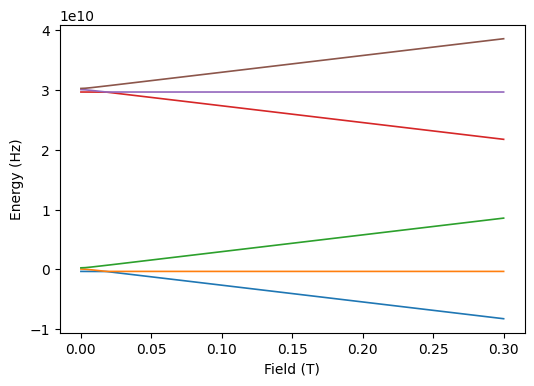

In [25]:
visualization.plot_energy_system(triplet, B_range=(0.0, 0.3))

Let's define complex context

In [26]:
# We set context for the first subsystem
context_zfs_1 = population.Context(sample=triplet_1, basis="zfs", init_populations=init_populations, out_probs=out_probs, device=device, dtype=dtype)

# We set context for the second subsystem. Let it be the same again
context_zfs_2 = population.Context(sample=triplet_2, basis="zfs", init_populations=init_populations, out_probs=out_probs, device=device, dtype=dtype)

#---------- Let set some relaxation probabilities between subsystems.s-----------------
dim = 6 # 6 energy levels
probs_echange = torch.zeros((dim, dim), device=device, dtype=dtype)

relaxation_rate = 1e2 # relaxation probabiltiy value
probs_echange[3, 0] = relaxation_rate  # relaxation from Ms=-1 of high-lying triplet state to Ms=-1 of low-lying triplet state
probs_echange[4, 1] = 2 * relaxation_rate  # relaxation from Ms=0 of high-lying triplet state to Ms=0 of low-lying triplet state
probs_echange[5, 2] = 3 * relaxation_rate  # relaxation from Ms=1 of high-lying triplet state to Ms=1 of low-lying triplet state

context_exchange = population.Context(sample=triplet, basis="eigen", free_probs=probs_echange, device=device, dtype=dtype)  # set in the eigen basis


# And create complex realaxation context
context_concat = mars.concat((context_zfs_1, context_zfs_2)) + context_exchange

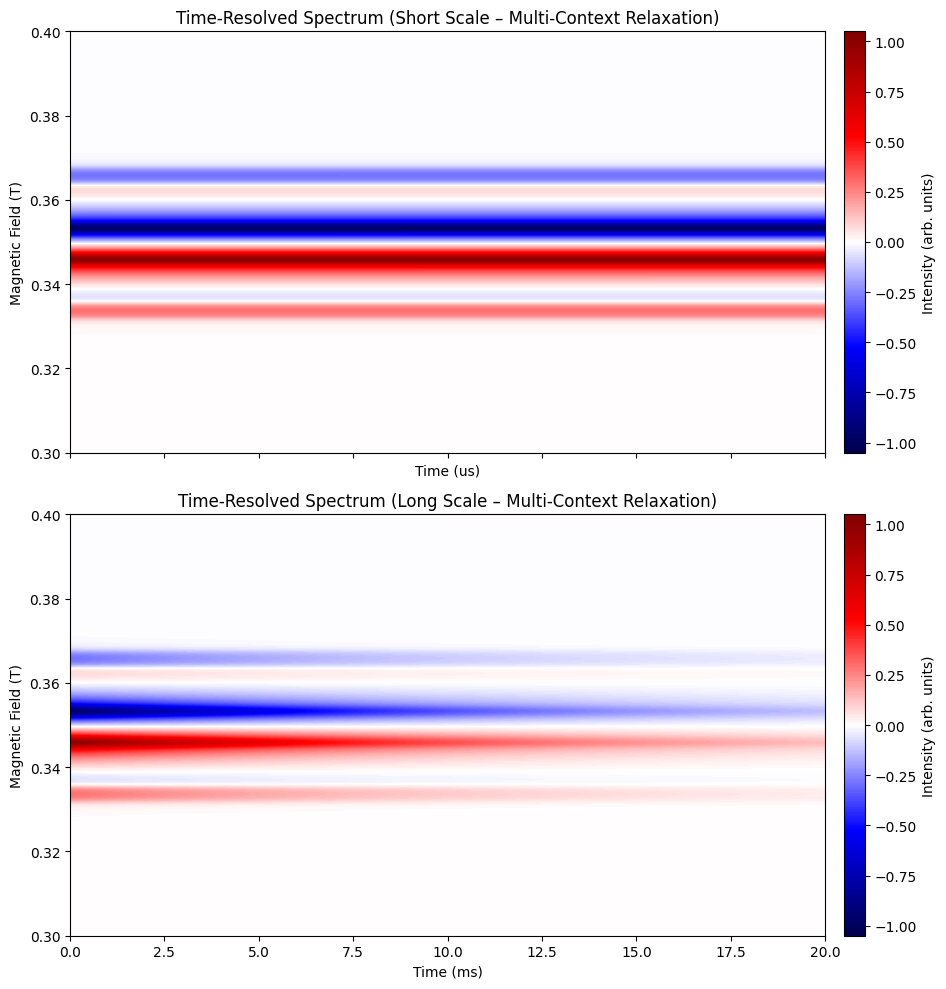

In [27]:
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(
    freq=9.8e9, 
    sample=triplet,   # Now we here another sample with 6 levels
    harmonic=0,
    context=context_concat,  # Here we set mulal relaxation context
    temperature=300.0,
    device=device,
    dtype=dtype
)

fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device) 
mul_points = 800
time_long = torch.linspace(0.0, 2e-2, mul_points, dtype=dtype, device=device)
time_short = torch.linspace(0.0, 3e-4, mul_points, dtype=dtype, device=device)

spectrum_mul_long  = tr_spectra_creator(triplet, fields, time_long)
spectrum_mul_short = tr_spectra_creator(triplet, fields, time_short)

# Normalize
normalization = np.max(np.abs(spectrum_mul_long.cpu().numpy()))
spectrum_mul_long_np = spectrum_mul_long.cpu().numpy() / normalization
spectrum_mul_short_np = spectrum_mul_short.cpu().numpy() / normalization

# Plotting
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Short timescale
plt.sca(ax0)
visualization.plot_2d_timeresolved(
    fields, time_short, spectrum_mul_short_np,
    time_unit="us",
)
plt.title("Time-Resolved Spectrum (Short Scale – Multi-Context Relaxation)")

# Long timescale
plt.sca(ax1)
visualization.plot_2d_timeresolved(
    fields, time_long, spectrum_mul_long_np,
    time_unit="ms",
)
plt.title("Time-Resolved Spectrum (Long Scale – Multi-Context Relaxation)")

plt.tight_layout()
plt.show()